# Inflating and Converting Currency

## Background

This notebook serves to show a brief and simple example of how to use the `convert_currency()` and `inflate_currency()` methods from pyjanitor's finance submodule.

The data for this example notebook come from the [United States Department of Agriculture Economic Research Service](https://www.ers.usda.gov/data-products/food-expenditure-series/), and we are specifically going to download the data of nominal food and alcohol expenditures, with taxes and tips, for all purchasers.  The data set includes nominal expenditures for 1997-2018, and the expenditures are provided in **millions** of U.S. dollars for the year in the which the expenditures were made.  For example, the expenditure values for 1997 are in units of 1997 U.S. dollars, whereas expenditures for 2018 are in 2018 U.S. dollars.

## Getting and Cleaning the Data

In [1]:
import pandas as pd
import janitor

In [2]:
url = (
    "https://www.ers.usda.gov/webdocs/DataFiles/50606/nominal_expenditures.csv?v=9289.4"
)
# 1) Read in the data from .csv file
# 2) Clean up the column names
# 3) Remove any empty rows or columns
# 4) Melt the dataframe (from wide to long) to obtain "tidy" format
data = (
    pd.read_csv(
        url,
        usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        nrows=22,
        thousands=','
    )
        .clean_names()
    .remove_empty()
    .melt(id_vars=['year'], var_name='store_type', value_name='expenditure')

    )
data.head()

,year,store_type,expenditure
0,1997,fah_grocery_stores_sales_million_nominal_dolla...,270956.91
1,1998,fah_grocery_stores_sales_million_nominal_dolla...,273638.88
2,1999,fah_grocery_stores_sales_million_nominal_dolla...,283782.47
3,2000,fah_grocery_stores_sales_million_nominal_dolla...,286669.78
4,2001,fah_grocery_stores_sales_million_nominal_dolla...,296436.72


## Use inflate_currency() to Inflate All Values to 2018$

In [3]:
from janitor.finance import inflate_currency, convert_currency

# Use split-apply-combine strategy to obtain 2018$ values
# Group the data frame by year
grouped = data.groupby(['year'])
# Apply the inflate_currency() method to each group
# (Note that each group comes with a name; in this case,
#  the name corresponds to the year)
data_constant_dollar = grouped.apply(
    lambda x: x.inflate_currency(
        column_name='expenditure',
        country='USA',
        currency_year=x.name,
        to_year=2018,
        make_new_column=True
    )
)
data_constant_dollar.head()

,year,store_type,expenditure,expenditure_2018
0,1997,fah_grocery_stores_sales_million_nominal_dolla...,270956.91,423875.807122
1,1998,fah_grocery_stores_sales_million_nominal_dolla...,273638.88,421528.097543
2,1999,fah_grocery_stores_sales_million_nominal_dolla...,283782.47,427793.590858
3,2000,fah_grocery_stores_sales_million_nominal_dolla...,286669.78,418029.852893
4,2001,fah_grocery_stores_sales_million_nominal_dolla...,296436.72,420391.299188


## Plot Time Series to Observe Currency Inflation

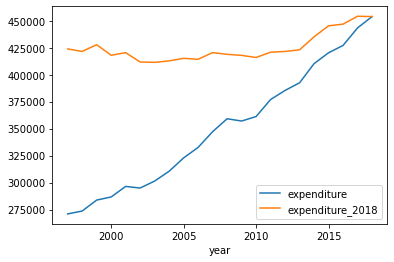

In [4]:
# Plot time series of nominal and real (2018$) expenditures for grocery stores
# Note that the 2018 values for both series should be equal
(
    data_constant_dollar
    .loc[data_constant_dollar['store_type'].str.contains('grocery_stores'), :]
    .set_index('year')
    .drop(columns='store_type')
    .plot()

)

## Use convert_currency() to Convert USD to British Pounds

In [5]:
from datetime import date

# Apply the convert_currency() method to the 'expenditure_2018' column
# Use the exchange rate from Dec. 31, 2018, since our data are in 2018$
data_constant_pounds = (
    data_constant_dollar
    .convert_currency(
        column_name='expenditure_2018',
        from_currency='USD',
        to_currency='GBP',
        historical_date=date(2018, 12, 31),
        make_new_column=True
    )
)
data_constant_pounds.head()                    

,year,store_type,expenditure,expenditure_2018,expenditure_2018_GBP
0,1997,fah_grocery_stores_sales_million_nominal_dolla...,270956.91,423875.807122,331152.511569
1,1998,fah_grocery_stores_sales_million_nominal_dolla...,273638.88,421528.097543,329318.366023
2,1999,fah_grocery_stores_sales_million_nominal_dolla...,283782.47,427793.590858,334213.275836
3,2000,fah_grocery_stores_sales_million_nominal_dolla...,286669.78,418029.852893,326585.366209
4,2001,fah_grocery_stores_sales_million_nominal_dolla...,296436.72,420391.299188,328430.243550


## Plot Time Series to Observe Currency Conversion

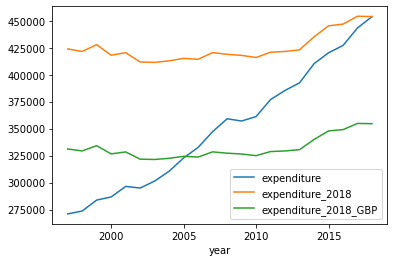

In [6]:
# You can see from this plot that GBP were worth more than USD on Dec. 31, 2018
# (by about 1.3x, it appears)
(
    data_constant_pounds
    .loc[data_constant_pounds['store_type'].str.contains('grocery_stores'), :]
    .set_index('year')
    .drop(columns='store_type')
    .plot()
)